In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [2]:
import keras
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import bayesflow as bf

INFO:2025-12-03 16:54:16,813:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:bayesflow:Using backend 'jax'


In [3]:
np.set_printoptions(suppress=True)

# We don't worry about jax determinism, for now. Only Keras.
keras.utils.set_random_seed(2026)
rng = np.random.default_rng(2026)

In [4]:
def prior():

    x = rng.normal(size=4)
    # logit normal distribution scaled to range from 0.1 and 4
    theta = 1/(1+np.exp(-x)) * 3.9 + 0.1 
    return dict(
        alpha=theta[0],
        beta=theta[1],
        gamma=theta[2],
        delta=theta[3],
    )


def lotka_volterra_equations(state, t, alpha, beta, gamma, delta):
    x, y = state
    dxdt = alpha * x - beta * x * y
    dydt = - gamma * y + delta * x * y
    return [dxdt, dydt]


def ecology_model(alpha, beta, gamma, delta, t_span=[0, 5], t_steps=100, initial_state=[1, 1]):
    t = np.linspace(t_span[0], t_span[1], t_steps)
    state = odeint(lotka_volterra_equations, initial_state, t, args=(alpha, beta, gamma, delta))
    x, y = state.T
    
    return dict(
        x=x,  # Prey time series
        y=y,  # Predator time series
        t=t,  # Time vector
    )


def observation_model(x, y, t, subsample=10, obs_prob=1.0, noise_scale=0.1):

    t_steps = x.shape[0]
    
    # Add Gaussian noise to observations
    noisy_x = rng.normal(x, noise_scale)
    noisy_y = rng.normal(y, noise_scale)
    
    # Determine which time steps are observed
    step_indices = np.arange(0, t_steps, subsample)
    num_observed = int(obs_prob * len(step_indices))
    observed_indices = np.sort(rng.choice(step_indices, num_observed, replace=False))

    return {
        "observed_x": noisy_x[observed_indices],
        "observed_y": noisy_y[observed_indices],
        "observed_t": t[observed_indices]
    }

In [5]:
p = prior()
p

{'alpha': np.float64(1.3148445672500593),
 'beta': np.float64(2.2834322704027272),
 'gamma': np.float64(0.6090468149948529),
 'delta': np.float64(3.2258970550948094)}

In [6]:
observation_model(**ecology_model(**p))

{'observed_x': array([ 1.06382947,  0.30877014,  0.11606098, -0.07443925,  0.06560553,
        -0.04026803, -0.08785976,  0.11564338,  0.04184632,  0.01804696]),
 'observed_y': array([1.13964531, 2.09557994, 2.00040578, 1.43827232, 1.01243393,
        0.90554781, 0.87327022, 0.362658  , 0.40740723, 0.26668791]),
 'observed_t': array([0.        , 0.50505051, 1.01010101, 1.51515152, 2.02020202,
        2.52525253, 3.03030303, 3.53535354, 4.04040404, 4.54545455])}

In [7]:
simulator = bf.make_simulator(
    [prior, ecology_model, observation_model]
)

In [8]:
num_trajectories = 100
samples = simulator.sample(num_trajectories)
keras.tree.map_structure(keras.ops.shape, samples)

{'alpha': (100, 1),
 'beta': (100, 1),
 'gamma': (100, 1),
 'delta': (100, 1),
 'x': (100, 100),
 'y': (100, 100),
 't': (100, 100),
 'observed_x': (100, 10),
 'observed_y': (100, 10),
 'observed_t': (100, 10)}

In [9]:
samples["alpha"]

array([[1.09238481],
       [1.4647794 ],
       [1.46718967],
       [1.86765678],
       [1.8593471 ],
       [3.27559638],
       [2.75817106],
       [2.93523184],
       [2.70612517],
       [2.39726507],
       [2.0560526 ],
       [3.607572  ],
       [0.66973872],
       [1.40523731],
       [2.08109375],
       [2.49904314],
       [2.92076308],
       [2.08483584],
       [2.93485953],
       [1.4365732 ],
       [1.41297478],
       [3.80802474],
       [1.11911562],
       [3.38564821],
       [1.10575011],
       [1.97180297],
       [2.13494944],
       [1.91250653],
       [1.82551283],
       [3.33576749],
       [1.0608683 ],
       [1.50590986],
       [2.35221183],
       [1.8294686 ],
       [2.96640049],
       [2.7593444 ],
       [2.29618493],
       [1.49921494],
       [1.48100677],
       [1.3320882 ],
       [3.46743812],
       [2.85203616],
       [1.14260735],
       [2.32770871],
       [2.62924438],
       [3.26613465],
       [1.59616944],
       [1.066

In [10]:
def trajectory_aggregation(traj, confidence=0.95):
    alpha = 1 - confidence
    quantiles = np.quantile(traj, [alpha/2, 0.5, 1-alpha/2], axis=0).T
    central = quantiles[:,1]
    L = quantiles[:,0]
    U = quantiles[:,2]
    return central, L, U

def plot_trajectories(samples, variable_keys, variable_names, fill_colors=["blue", "darkred"], confidence=0.95, alpha=0.8, observations=None, ax=None):
    t_span = samples["t"][0]
    
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(12,3))
        sns.despine()
    
    for i, key in enumerate(variable_keys):

        if observations is not None:     
            ax.scatter(observations["observed_t"], observations["observed_"+key], color=fill_colors[i], marker="x", label="Observed " + variable_names[i].lower())

        central, L, U = trajectory_aggregation(samples[key], confidence=confidence)
        ax.plot(t_span, central, color=fill_colors[i], label="Median " + variable_names[i].lower())
        ax.fill_between(t_span, L, U, color=fill_colors[i], alpha=0.2, label=rf"{int((confidence) * 100)}$\%$ Confidence Bands")

        # plot 20 trajectory samples
        for j in range(20):
            if j == 0:
                label = f"{variable_names[i]} trajectories"
            else:
                label = None
            ax.plot(t_span, samples[key][j], color=fill_colors[i], alpha=0.2, label=label)
        

    ax.legend()
    ax.set_xlabel("t")
    ax.set_ylabel("population")

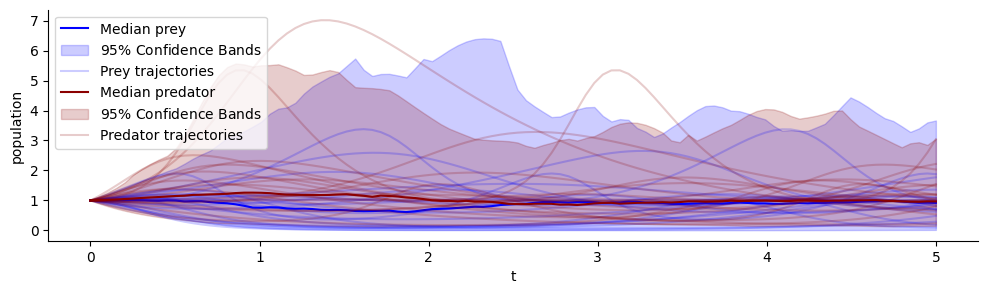

In [11]:
plot_trajectories(samples, ["x", "y"], ["Prey", "Predator"])

In [18]:
adapter = (
    bf.adapters.Adapter()
    .convert_dtype("float64", "float32")
    .drop(["x", "y", "t"])
    .as_time_series(["observed_x", "observed_y", "observed_t"])
    .concatenate(["alpha", "beta", "gamma", "delta"], into="inference_variables")
    .concatenate(["observed_x", "observed_y", "observed_t"], into="summary_variables")
)

In [19]:
adapter

Adapter([0: ConvertDType -> 1: Drop(['x', 'y', 't']) -> 2: AsTimeSeries -> 3: Concatenate(['alpha', 'beta', 'gamma', 'delta'] -> 'inference_variables') -> 4: Concatenate(['observed_x', 'observed_y', 'observed_t'] -> 'summary_variables')])

In [20]:
time_series_network = bf.networks.TimeSeriesNetwork()
flow_matching = bf.networks.FlowMatching()

In [21]:
e2e_workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    summary_network=time_series_network,
    inference_network=flow_matching
)

In [22]:
training_set = e2e_workflow.simulate(5000)
validation_set = e2e_workflow.simulate(300)

In [23]:
history = e2e_workflow.fit_offline(
    data=training_set, 
    epochs=50, 
    batch_size=32, 
    validation_data=validation_set
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 2.2940 - val_loss: 1.1778
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4385 - val_loss: 1.0746
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2138 - val_loss: 1.0785
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0713 - val_loss: 1.0143
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9890 - val_loss: 1.0083
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9297 - val_loss: 0.8356
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8974 - val_loss: 0.8084
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8503 - val_loss: 0.8447
Epoch 9/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8335 - val_loss: 0.7386
Epoch 10/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7970 - val_loss: 0.7248
Epoch 11/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7710 - val_loss: 0.7021
Epoch 12/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st

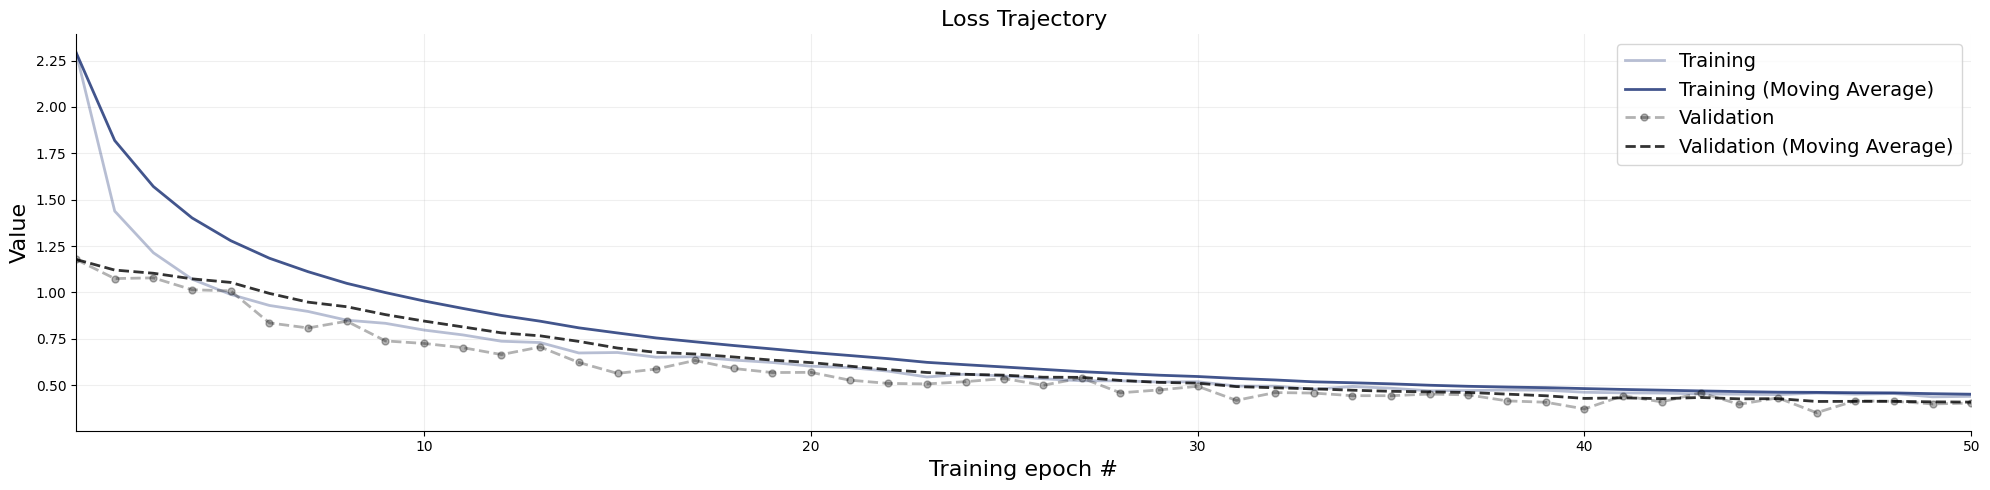

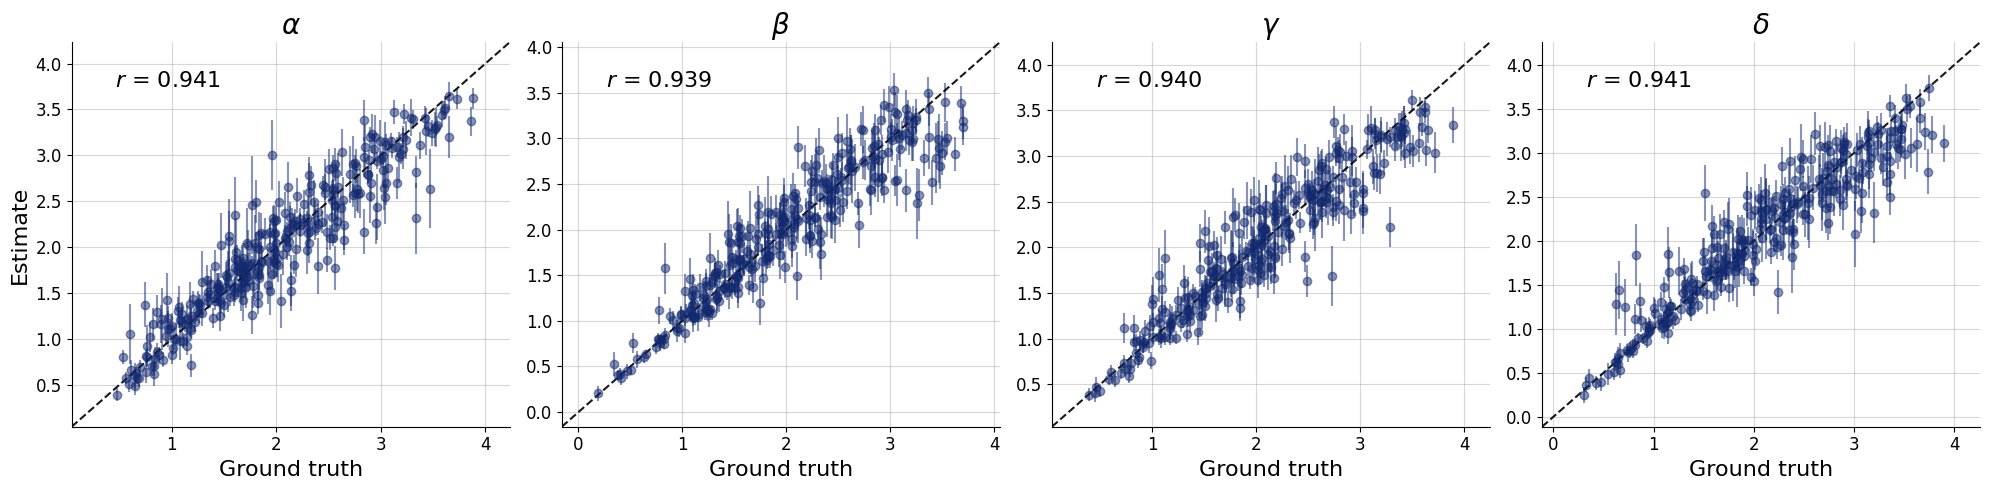

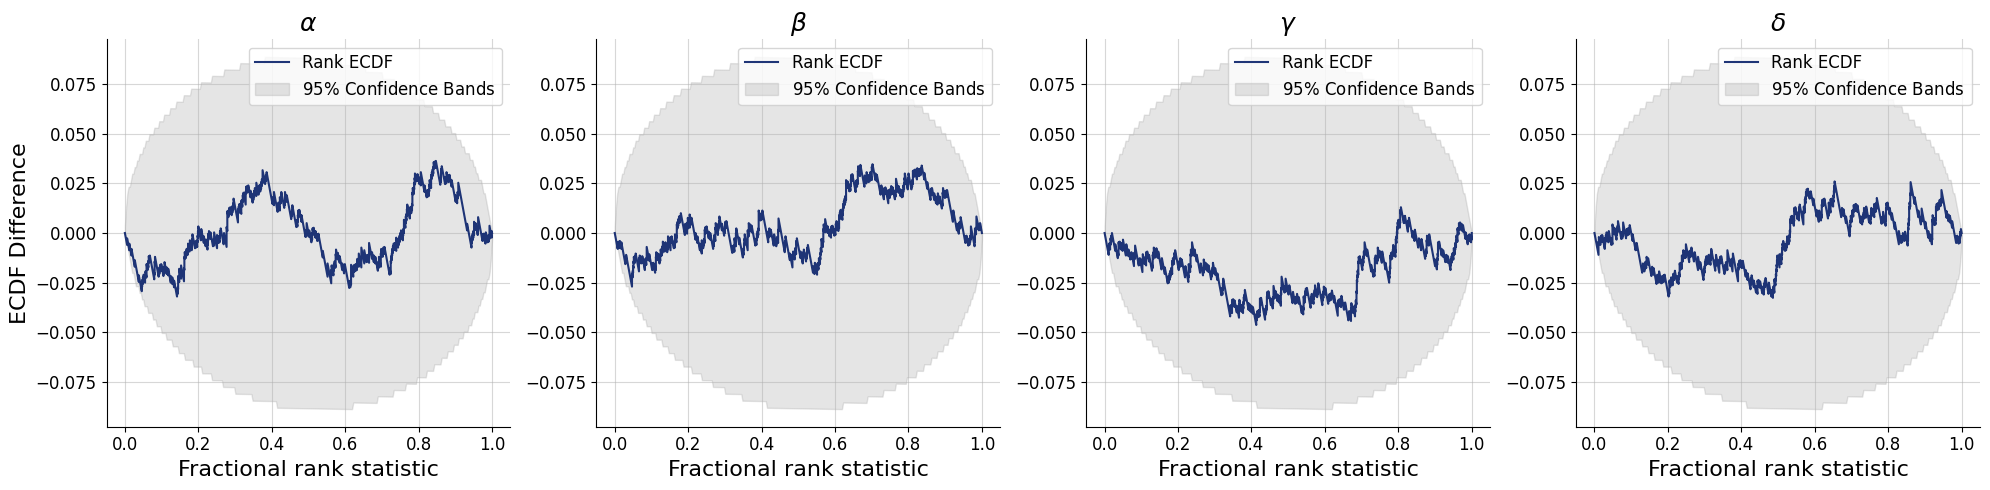

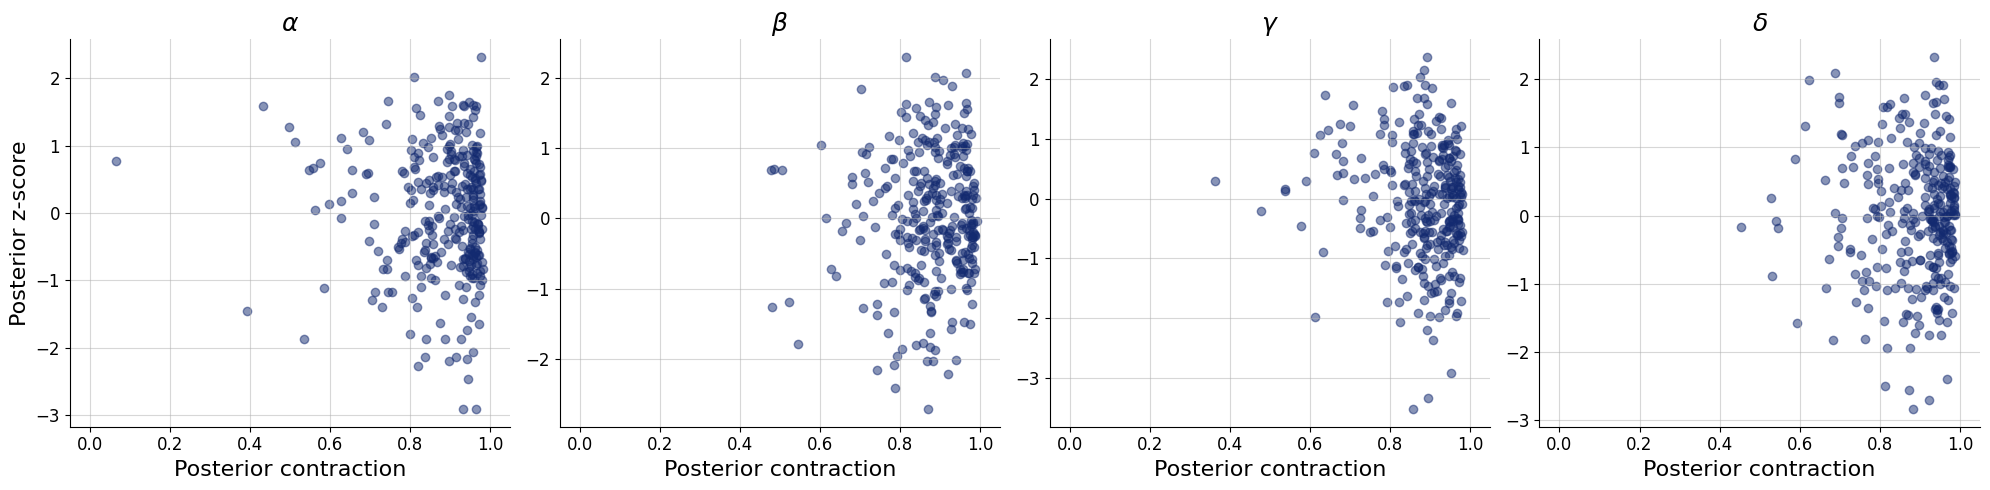

In [24]:
fig_size = (20, 5)

figures = e2e_workflow.plot_default_diagnostics(
    test_data=validation_set,
    variable_names=[r"$\alpha$", r"$\beta$", r"$\gamma$", r"$\delta$"],
    loss_kwargs={"figsize": fig_size, "label_fontsize": 16},
    recovery_kwargs={
        "figsize": fig_size,
        "label_fontsize": 16,
        "title_fontsize": 20,
    },
    calibration_ecdf_kwargs={
        "figsize": fig_size,
        "legend_fontsize": 12,
        "difference": True,
        "label_fontsize": 16,
    },
    z_score_contraction_kwargs={"figsize": fig_size, "label_fontsize": 16},
)

In [25]:
metrics = e2e_workflow.compute_default_diagnostics(test_data=validation_set, variable_names=[r"$\alpha$", r"$\beta$", r"$\gamma$", r"$\delta$"])

In [26]:
metrics

,$\alpha$,$\beta$,$\gamma$,$\delta$
NRMSE,0.114086,0.112706,0.110282,0.115644
Posterior Contraction,0.915916,0.884612,0.900041,0.921839
Calibration Error,0.028684,0.019298,0.004035,0.022456


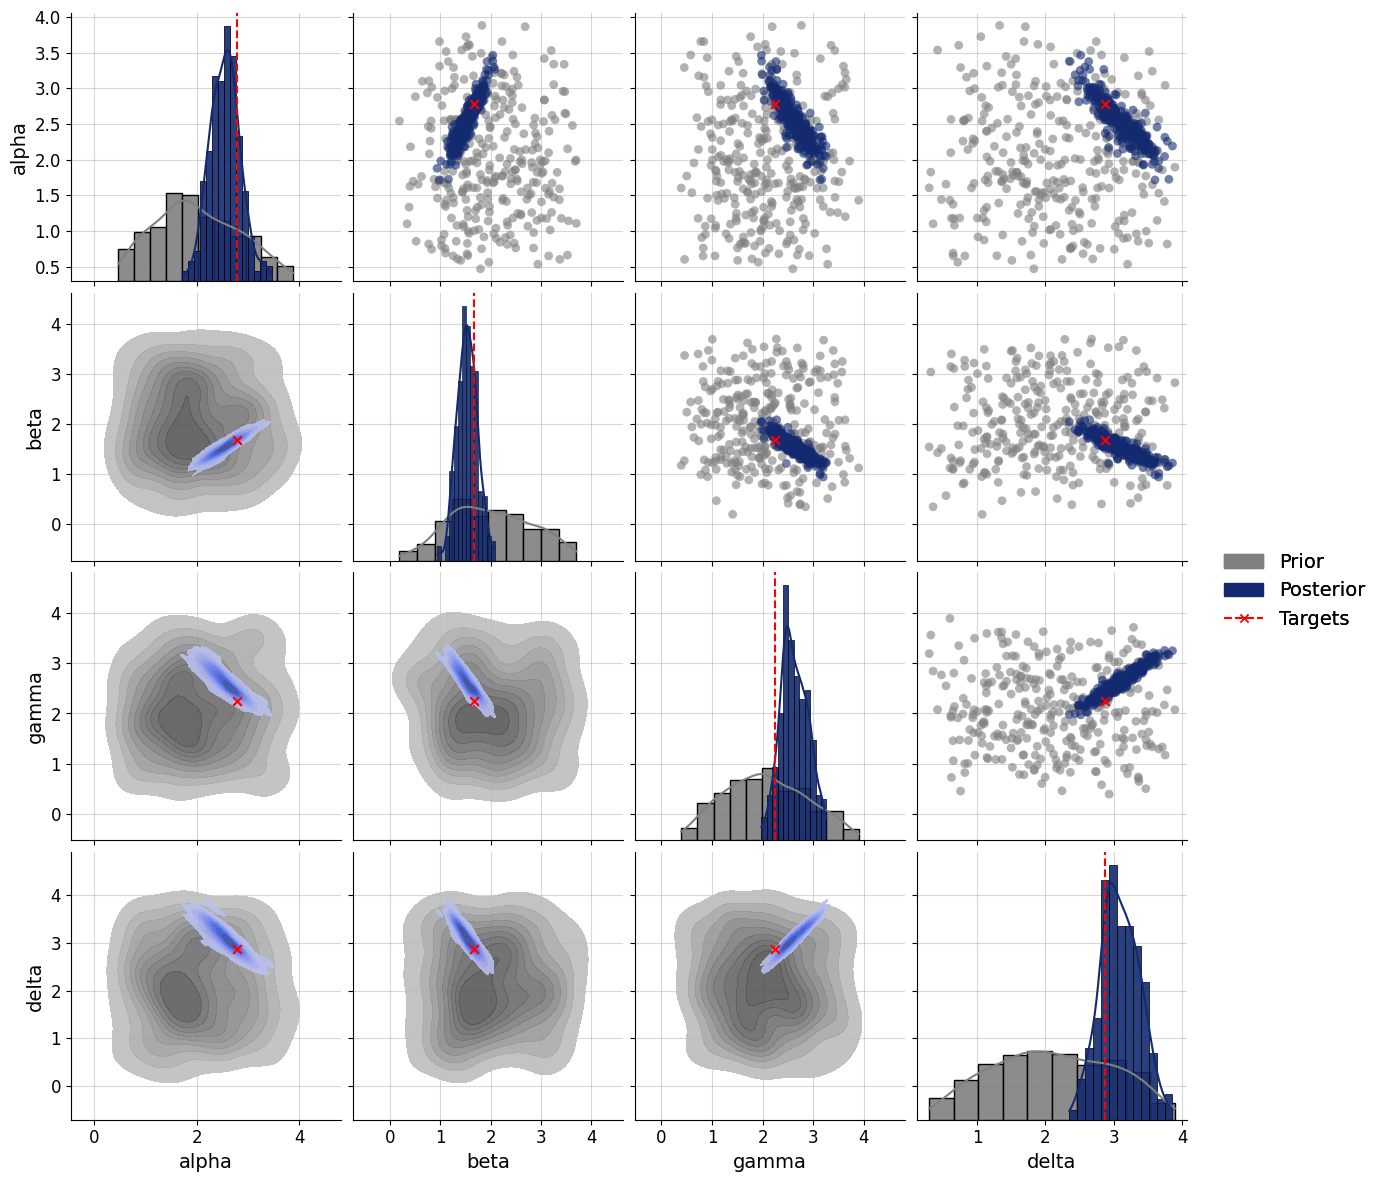

In [27]:
estimates = e2e_workflow.sample(num_samples=300, conditions=validation_set)

f = bf.diagnostics.plots.pairs_posterior(
    estimates=estimates, 
    targets=validation_set,
    dataset_id=0,
    priors=validation_set
)

In [28]:
def take_posterior_sample(post_draws, dataset_id, sample_id):
    """Helper function to return a single sample for a single data set."""
    posterior_sample_for_id = {var_key: post_draws[var_key][dataset_id, sample_id,...].squeeze() for var_key in post_draws.keys()}
    return posterior_sample_for_id

def take_dataset(sims, dataset_id):
    """Helper function to return a single simulation from a dictionary of simulations."""
    return {var_key: sims[var_key][dataset_id] for var_key in sims.keys()}

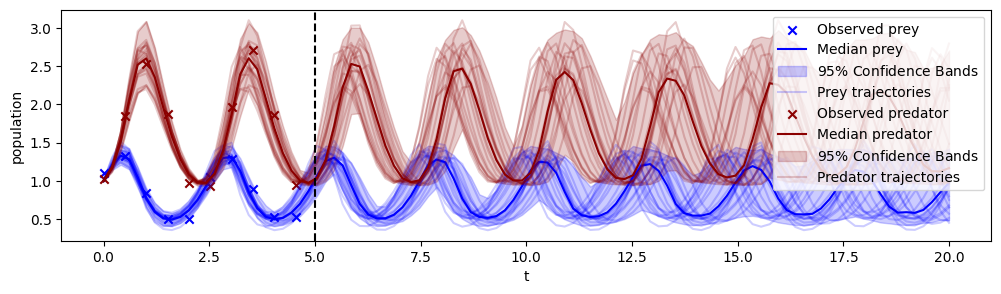

In [30]:
dataset_id = 0
num_samples = 300

list_of_resimulations = []

posterior_draws = e2e_workflow.sample(num_samples=300, conditions=validation_set)

for sample_id in range(num_samples):
    one_post_sample = take_posterior_sample(posterior_draws, dataset_id, sample_id)
    list_of_resimulations.append(ecology_model(t_span=[0,20], **one_post_sample))

resimulation_samples = bf.utils.tree_stack(list_of_resimulations, axis=0)

observations = take_dataset(validation_set, dataset_id)

f, ax = plt.subplots(1, 1, figsize=(12, 3))
plot_trajectories(resimulation_samples, ["x", "y"], ["Prey", "Predator"], observations=observations, ax=ax)
ax.axvline([5], color="black", linestyle="dashed")

## Expert Summary Statistics

In [49]:
from scipy.signal import periodogram

def period(observed_x, t_span=[0, 5], t_steps=500):
    """
    Computes the dominant period of observed_x from a periodogram.
    """
    f, Pxx = periodogram(observed_x, t_steps/(t_span[1]-t_span[0]))
    freq_dominant = f[np.argmax(Pxx)]
    T = 1 / freq_dominant
    return T


def autocorr(trajectory, lags):
    """
    Computes the autocorrelation for each specified lag in a trajectory.
    
    Parameters
    ----------
    trajectory : np.ndarray
        The time series data, assumed to be a 1D array.
    lags : np.ndarray or list
        The lags at which to compute the autocorrelation.
    
    Returns
    -------
    auto_correlation : np.ndarray
        Autocorrelation values at each specified lag.
    """
    # Calculate the mean and variance of the trajectory for normalization
    mean = np.mean(trajectory)
    var = np.var(trajectory)
    
    # Initialize an array to hold the autocorrelation values
    auto_correlation = np.zeros(len(lags))
    
    # Compute autocorrelation for each lag
    for i, lag in enumerate(lags):
        if lag == 0:
            # Autocorrelation at lag 0 is always 1
            auto_correlation[i] = 1
        elif lag >= len(trajectory):
            # If the lag is equal to or greater than the length of the trajectory, autocorrelation is undefined (set to 0)
            auto_correlation[i] = 0
        else:
            # Compute covariance and then autocorrelation
            cov = np.mean((trajectory[:-lag] - mean) * (trajectory[lag:] - mean))
            auto_correlation[i] = cov / var

    if np.any(np.isnan(auto_correlation)):
        print(auto_correlation)
            
    return auto_correlation

def crosscorr(x, y):
    """
    Computes the cross-correlation (Pearson correlation coefficient) between two trajectories at zero lag.

    Parameters
    ----------
    x : np.ndarray
        The first time series data, assumed to be a 1D array of length n.
    y : np.ndarray
        The second time series data, assumed to be a 1D array of length n.

    Returns
    -------
    float
        The cross-correlation coefficient.
    """
    # Compute the mean and standard deviation of both time series
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    std_x = np.std(x)
    std_y = np.std(y)

    # Compute the covariance and the correlation coefficient
    covariance = np.mean((x - mean_x) * (y - mean_y))
    correlation = covariance / (std_x * std_y)

    return correlation

def expert_stats(observed_x, observed_y, lags=[2,5]):
    """Computes fixed size statistics for an observed population trajectory

    Parameters
    ----------
    observed_x : np.ndarray with shape (num_observations, )
    observed_y : np.ndarray with shape (num_observations, )

    Returns
    -------
    dictionary with the following keys and values
    means      : np.ndarray with shape (2,)
    log_vars   : np.ndarray with shape (2,)
    auto_corrs : np.ndarray with shape (2*num_lags,)
        auto-correlation of each timeseries at lags 0.2 and 0.4 time units
    cross_corr : np.ndarray with shape (1,)
        the cross-correlation between the two time series
    period     : np.ndarray with shape (1,)
    """
    means = np.array([observed_x.mean(), observed_y.mean()])
    log_vars = np.log(np.array([observed_x.var(), observed_y.var()]))
    auto_corrs = np.array([
        autocorr(observed_x,lags),
        autocorr(observed_y,lags),
    ]).flatten()
    cross_corr = crosscorr(observed_x, observed_y)
    T = period(observed_x)
    
    return dict(
        means=means,
        log_vars=log_vars,
        auto_corrs=auto_corrs,
        cross_corr=cross_corr,
        period=T,
    )

In [50]:
expert_simulator = bf.make_simulator(
    [prior, ecology_model, observation_model, expert_stats]
)

In [51]:
expert_adapter = (
    bf.adapters.Adapter()

    # convert from numpy's default float64 to deep learning friendly float32
    .convert_dtype("float64", "float32")

    # drop unobserved full trajectories and raw observations (optional)
    .drop(["x", "y", "t", "observed_x", "observed_y", "observed_t"])

    # rename the variables to match the required approximator inputs
    .concatenate(["alpha", "beta", "gamma", "delta"], into="inference_variables")
    .concatenate(["means", "log_vars", "auto_corrs", "cross_corr", "period"], into="inference_conditions")

)

In [52]:
expert_adapter

Adapter([0: ConvertDType -> 1: Drop(['x', 'y', 't', 'observed_x', 'observed_y', 'observed_t']) -> 2: Concatenate(['alpha', 'beta', 'gamma', 'delta'] -> 'inference_variables') -> 3: Concatenate(['means', 'log_vars', 'auto_corrs', 'cross_corr', 'period'] -> 'inference_conditions')])

In [53]:
quantile_levels = np.linspace(0.1, 0.9, 5)

In [54]:
point_inference_network = bf.networks.PointInferenceNetwork(
    scores=dict(
        mean=bf.scores.MeanScore(),
        quantiles=bf.scores.QuantileScore(quantile_levels)
    )
)

In [55]:
point_estimation_workflow = bf.BasicWorkflow(
    simulator=expert_simulator,
    adapter=expert_adapter,
    inference_network=point_inference_network
)

In [57]:
point_estimator_history = point_estimation_workflow.fit_online(
    epochs=50,
    num_batches_per_epoch=200,
    batch_size=32,
)

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.


Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.3027 - mean/inference_mean: 0.3894 - quantiles/inference_quantiles: 0.2160
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.3027 - mean/inference_mean: 0.4229 - quantiles/inference_quantiles: 0.1826
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.3438 - mean/inference_mean: 0.4809 - quantiles/inference_quantiles: 0.2068
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.2078 - mean/inference_mean: 0.2712 - quantiles/inference_quantiles: 0.1445
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.2759 - mean/inference_mean: 0.3643 - quantiles/inference_quantiles: 0.1874
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.1582 - mean/inference_mean: 0.1924 - quantiles/inference_quantiles: 0.1240
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.1354 - mean/inference_mean: 0.1554 - quantiles/inference_quantiles: 0.1154
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━

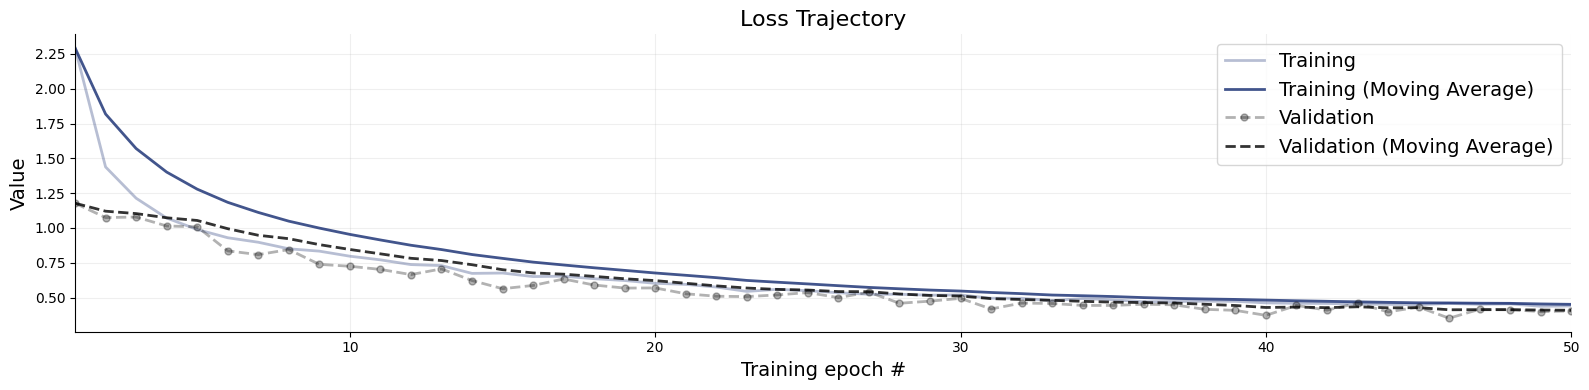

In [58]:
f = bf.diagnostics.loss(history)

In [69]:
validation_data = expert_simulator.sample(300)
variable_names = [r"$\alpha$", r"$\beta$", r"$\gamma$", r"$\delta$"]

In [72]:
# Set the number of posterior draws you want to get
point_estimates = point_estimation_workflow.approximator.estimate(conditions=validation_data)

In [73]:
keras.tree.map_structure(keras.ops.shape, point_estimates)

{'alpha': {'mean': (300, 1), 'quantiles': (300, 5, 1)},
 'beta': {'mean': (300, 1), 'quantiles': (300, 5, 1)},
 'gamma': {'mean': (300, 1), 'quantiles': (300, 5, 1)},
 'delta': {'mean': (300, 1), 'quantiles': (300, 5, 1)}}

In [74]:
marker_mapping = dict(quantiles="_", mean="*")

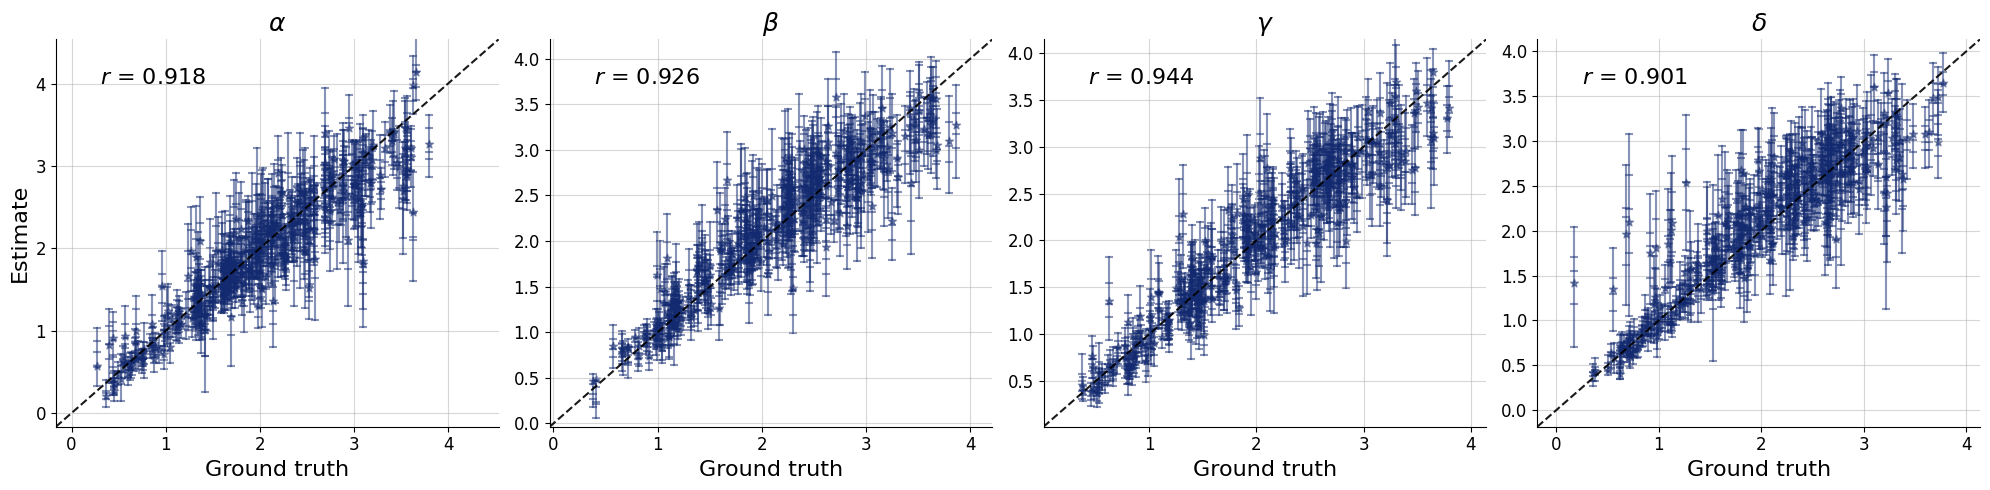

In [76]:
point_recovery = bf.diagnostics.plots.recovery_from_estimates(
    estimates=point_estimates, 
    targets=validation_data, 
    variable_names=variable_names,
    marker_mapping=marker_mapping
)

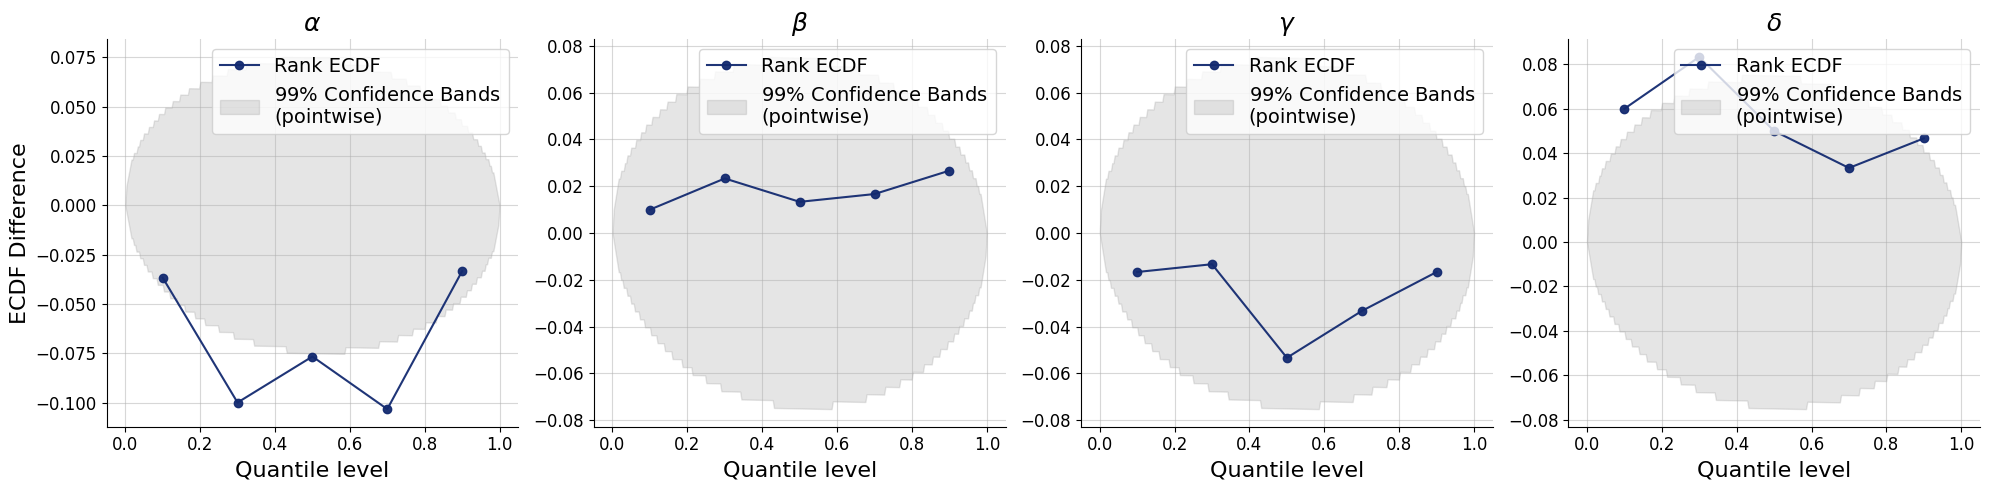

In [77]:
f = bf.diagnostics.plots.calibration_ecdf_from_quantiles(
    estimates=point_estimates, 
    targets=validation_data,
    quantile_levels=quantile_levels,
    difference=True,
    variable_names=variable_names,
)

In [78]:
posterior_bounds_from_quantiles = keras.tree.map_structure(
    lambda v: v[:,[0,-1]], {k:v["quantiles"] for k,v in point_estimates.items()}
)

In [79]:
from scipy.stats import norm

std_normal_quantiles = norm.ppf(quantile_levels[[0,-1]])
std_normal_quantiles

array([-1.28155157,  1.28155157])

In [80]:
# calculate interpolation value for mean and standard deviation
alpha = std_normal_quantiles[0] / (std_normal_quantiles[0] - std_normal_quantiles[1])
beta = (std_normal_quantiles[0] - 1) / (std_normal_quantiles[0] - std_normal_quantiles[1])

In [81]:
posterior_means_from_quantiles = keras.tree.map_structure(
    lambda v: v[:,0] * (1-alpha) + v[:,1] * alpha, posterior_bounds_from_quantiles
)
posterior_stds_from_quantiles = keras.tree.map_structure(
    lambda v: v[:,0] * (alpha-beta) + v[:,1] * (beta-alpha), posterior_bounds_from_quantiles
)

In [85]:
num_samples = 300

# sample from normal distribution consistent with quantile estimates
posterior_draws_from_quantiles = keras.tree.map_structure(
    lambda v: rng.normal(
    loc=v[:,0] * (1-alpha) + v[:,1] * alpha, 
    scale=v[:,0] * (alpha-beta) + v[:,1] * (beta-alpha),
    size=(500, num_samples))[..., None], posterior_bounds_from_quantiles
)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (500, 300) and arg 1 with shape (300, 1).

In [ ]:
list_of_resimulations = []
for sample_id in range(num_samples):
    one_post_sample = take_posterior_sample(posterior_draws_from_quantiles, dataset_id, sample_id)
    list_of_resimulations.append(ecology_model(t_span=[0,20], **one_post_sample))
resimulation_samples = bf.utils.tree_stack(list_of_resimulations, axis=0)

observations = take_dataset(val_sims, dataset_id)

plot_trajectores(resimulation_samples, ["x", "y"], ["Prey", "Predator"], observations=observations)
plt.xlim(0,5)
plt.title("Trajectories from posterior predictive distribution (diagonal normal approximation)");